### Model development

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, RobustScaler

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, EasyEnsembleClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import TomekLinks, NearMiss, ClusterCentroids
from imblearn.over_sampling import SMOTE, RandomOverSampler, BorderlineSMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
from sklearn.neighbors import NearestNeighbors


filepath = "C:/Users/WALDMJN/OneDrive - Schaeffler/Uni/Data Exploration Project/Pred Maintenance Project/Predictive-Maintenance/Data/predictive_maintenance.csv"
df = pd.read_csv(filepath)
df = df.drop(["UDI", "Product ID"], axis = 1)
df.head()


,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,M,298.1,308.6,1551,42.8,0,0,No Failure
1,L,298.2,308.7,1408,46.3,3,0,No Failure
2,L,298.1,308.5,1498,49.4,5,0,No Failure
3,L,298.2,308.6,1433,39.5,7,0,No Failure
4,L,298.2,308.7,1408,40.0,9,0,No Failure


Let's drop out the target anomalies from notebook before.

In [31]:
fail_df = df[df['Target'] == 1]
indexPossibleFailure = fail_df[fail_df['Failure Type'] == 'No Failure'].index
df.drop(indexPossibleFailure, axis=0, inplace=True)
df.shape[0]

9991

In [32]:
fail_df  = df[df['Target'] == 0]
indexPossibleFailure = fail_df[fail_df['Failure Type'] == 'Random Failures'].index
df.drop(indexPossibleFailure, axis=0, inplace=True)
df.shape[0]

9973

### Feature Engineering

In [33]:
df['Power [W]'] = df['Torque [Nm]'] * (2 * np.pi * df['Rotational speed [rpm]'] / 60.0)
df['Overstrain [minNm]'] = df['Torque [Nm]'] * df['Tool wear [min]']
df['Heat dissipation [rpminK]'] = abs(df['Air temperature [K]'] - df['Process temperature [K]']) * df['Rotational speed [rpm]']

df.head(5)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Power [W],Overstrain [minNm],Heat dissipation [rpminK]
0,M,298.1,308.6,1551,42.8,0,0,No Failure,6951.590560,0.0,16285.5
1,L,298.2,308.7,1408,46.3,3,0,No Failure,6826.722724,138.9,14784.0
2,L,298.1,308.5,1498,49.4,5,0,No Failure,7749.387543,247.0,15579.2
3,L,298.2,308.6,1433,39.5,7,0,No Failure,5927.504659,276.5,14903.2
4,L,298.2,308.7,1408,40.0,9,0,No Failure,5897.816608,360.0,14784.0


In [34]:
encoder = OrdinalEncoder()
df[['Type', 'Failure Type']] = encoder.fit_transform(df[['Type', 'Failure Type']])

In [35]:
print(df.columns)

Index(['Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target',
       'Failure Type', 'Power [W]', 'Overstrain [minNm]',
       'Heat dissipation [rpminK]'],
      dtype='object')


The RobustScaler on Rotational Speed and Torque is necessary because of strong outliers.

In [36]:
# Create a copy of the original dataframe
df_scaled = df.copy()


# Define the columns to be scaled
columns = ['Rotational speed [rpm]', 'Torque [Nm]', 'Power [W]', 'Overstrain [minNm]', 'Heat dissipation [rpminK]']

# Initialize the RobustScaler
scaler = RobustScaler()

# Fit and transform the specified columns in the dataframe
features_scaled = scaler.fit_transform(df[columns])

# Convert the scaled features back to a DataFrame
features_scaled = pd.DataFrame(features_scaled, columns=columns)

# Drop the original columns from the dataframe
df_scaled.drop(columns, axis=1, inplace=True)

# Concatenate the scaled features back to the dataframe
df_scaled = pd.concat([df, features_scaled], axis=1)

# Display the first 5 rows of the scaled dataframe
df_scaled.head(5)


,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Power [W],Overstrain [minNm],Heat dissipation [rpminK],Rotational speed [rpm],Torque [Nm],Power [W],Overstrain [minNm],Heat dissipation [rpminK]
0,2.0,298.1,308.6,1551.0,42.8,0.0,0.0,1.0,6951.590560,0.0,16285.5,0.253968,0.200000,0.474003,-0.929070,0.381501
1,1.0,298.2,308.7,1408.0,46.3,3.0,0.0,1.0,6826.722724,138.9,14784.0,-0.502646,0.459259,0.387271,-0.896863,-0.122967
2,1.0,298.1,308.5,1498.0,49.4,5.0,0.0,1.0,7749.387543,247.0,15579.2,-0.026455,0.688889,1.028150,-0.871797,0.144201
3,1.0,298.2,308.6,1433.0,39.5,7.0,0.0,1.0,5927.504659,276.5,14903.2,-0.370370,-0.044444,-0.237322,-0.864957,-0.082919
4,1.0,298.2,308.7,1408.0,40.0,9.0,0.0,1.0,5897.816608,360.0,14784.0,-0.502646,-0.007407,-0.257943,-0.845596,-0.122967


Air temperature, Process temperature and tool wear get scaled over MinMaxScaler.

In [37]:
# Define the columns to be scaled
columns = ['Air temperature [K]', 'Process temperature [K]', 'Tool wear [min]']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the specified columns in the dataframe
features_scaled = scaler.fit_transform(df[columns])

# Convert the scaled features back to a DataFrame
features_scaled = pd.DataFrame(features_scaled, columns=columns)

# Drop the original columns from the dataframe
df.drop(columns, axis=1, inplace=True)

# Concatenate the scaled features back to the dataframe
df_scaled = pd.concat([df, features_scaled], axis=1)

# Display the first few rows of the scaled dataframe
df_scaled.head()


,Type,Rotational speed [rpm],Torque [Nm],Target,Failure Type,Power [W],Overstrain [minNm],Heat dissipation [rpminK],Air temperature [K],Process temperature [K],Tool wear [min]
0,2.0,1551.0,42.8,0.0,1.0,6951.590560,0.0,16285.5,0.304348,0.358025,0.000000
1,1.0,1408.0,46.3,0.0,1.0,6826.722724,138.9,14784.0,0.315217,0.370370,0.011858
2,1.0,1498.0,49.4,0.0,1.0,7749.387543,247.0,15579.2,0.304348,0.345679,0.019763
3,1.0,1433.0,39.5,0.0,1.0,5927.504659,276.5,14903.2,0.315217,0.358025,0.027668
4,1.0,1408.0,40.0,0.0,1.0,5897.816608,360.0,14784.0,0.315217,0.370370,0.035573


It is important that the values for training data and test data are well divided, as there is a small number of errors, especially in the existing data set. 

In [38]:
# Prepare features and target
X = df.drop(['Target', 'Failure Type'], axis=1)
y = df['Target']

# Reset indices
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

# Stratified shuffle split
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=42)

# Create train-test splits
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

# Check target proportions
print('Checking the stratified split...')
print('Target proportion in original dataset:')
print(df['Target'].value_counts(normalize=True))

print('Target proportion in y_train dataset:')
print(y_train.value_counts(normalize=True))

print('Target proportion in y_test dataset:')
print(y_test.value_counts(normalize=True))


Checking the stratified split...
Target proportion in original dataset:
Target
0    0.966911
1    0.033089
Name: proportion, dtype: float64
Target proportion in y_train dataset:
Target
0    0.966974
1    0.033026
Name: proportion, dtype: float64
Target proportion in y_test dataset:
Target
0    0.96672
1    0.03328
Name: proportion, dtype: float64


Y_Train and Y_Test have an equally good distribution and a small difference in the target values.

### Model Training and Testing

Specifically, we aim to classify whether a machine is functioning correctly or if it is experiencing a fault. This initial step of binary classification - distinguishing between "faulty" and "operational" states - serves several crucial purposes:

- Simplicity and Clarity
- Early Fault Detection
- Resource Allocation

Given our binary classification problem, we want to test a variety of machine learning models to determine which one performs best on our dataset. The models we plan to test include:

- Logistic Regression: A simple yet effective linear model for binary classification.
- Decision Tree Classifier: Easy to interpret and visualize, capturing non-linear relationships.
- Random Forest Classifier: An ensemble method that builds multiple decision trees to improve accuracy and reduce overfitting.
- Balanced Random Forest Classifier:
- Gradient Boosting Classifier: Sequentially builds trees, each one correcting the errors of the previous one. We will also test variants like XGBoost, LightGBM, and CatBoost.
- Bagging Classifier:
- Balanced Bagging Classifier:
- Easy Ensemble Classifier:
- Support Vector Machine:


In [39]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'Bagging Classifier': BaggingClassifier(random_state=42),
    'Balanced Random Forest': BalancedRandomForestClassifier(random_state=42, n_jobs=-1),
    'Balanced Bagging': BalancedBaggingClassifier(random_state=42, n_jobs=-1),
    'Easy Ensemble': EasyEnsembleClassifier(random_state=42),
    'SVC': SVC(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Decision Tree Classifier': DecisionTreeClassifier(random_state=42)
}

results_df = pd.DataFrame()

for name, model in models.items():
    print(f'Fitting {name}')
    
    # Cross validation metrics test data
    scoring = ["f1_macro", "precision_macro", "recall_macro", "roc_auc"]
    cross_val_scores = cross_validate(model, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    
    # Calculate metrics
    f1_test_cv = round(cross_val_scores["test_f1_macro"].mean(), 4)
    precision_test_cv = round(cross_val_scores["test_precision_macro"].mean(), 4)
    recall_test_cv = round(cross_val_scores["test_recall_macro"].mean(), 4)
    roc_auc_test_cv = round(cross_val_scores["test_roc_auc"].mean(), 4)
    
    # Summary table
    score_df = pd.DataFrame({
                     'f1': f1_test_cv,
                     'precision': precision_test_cv,
                     'recall': recall_test_cv,
                     'roc_auc': roc_auc_test_cv},
                     index=[name])

    results_df = pd.concat([results_df, score_df])

results_df = results_df.sort_values(by='f1', ascending=False)
print(results_df.round(4))

# Get the names of the top 3 classifiers
top_3_classifiers = results_df.head(3).index

# Train and display confusion matrices for the top 3 classifiers
for name in top_3_classifiers:
    model = models[name]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f'Confusion Matrix for {name}:')
    print(confusion_matrix(y_test, y_pred))
    print()


Fitting Logistic Regression
Fitting Random Forest
Fitting Bagging Classifier
Fitting Balanced Random Forest
Fitting Balanced Bagging
Fitting Easy Ensemble
Fitting SVC
Fitting Gradient Boosting
Fitting Decision Tree Classifier
                              f1  precision  recall  roc_auc
Random Forest             0.9315     0.9575  0.9084   0.9748
Bagging Classifier        0.9308     0.9621  0.9038   0.9450
Gradient Boosting         0.9230     0.9356  0.9113   0.9815
Decision Tree Classifier  0.9098     0.9099  0.9102   0.9102
Balanced Bagging          0.7745     0.7076  0.9335   0.9827
Balanced Random Forest    0.7230     0.6616  0.9274   0.9843
Easy Ensemble             0.6928     0.6389  0.9077   0.9702
Logistic Regression       0.5381     0.8111  0.5248   0.8320
SVC                       0.5129     0.9837  0.5108   0.9235
Confusion Matrix for Random Forest:
[[2405    6]
 [  16   67]]

Confusion Matrix for Bagging Classifier:
[[2405    6]
 [  19   64]]

Confusion Matrix for Gradient B

The top three classifiers based on F1 score are:

1. Bagging Classifier: F1 score of 0.8626 with a confusion matrix showing high precision and recall.
2. Random Forest: F1 score of 0.8449, slightly lower than Bagging, but with excellent precision and roc_auc.
3. Decision Tree Classifier: F1 score of 0.8437, closely following Random Forest, with balanced precision and recall.
4. Gradient Boosting: F1 score of 0.8405, slightly lower than Decision Tree, but with high precision and roc_auc.

These models demonstrate strong performance, particularly in precision and roc_auc, indicating effective classification capabilities.

### Summary on Sampling and Hyperparameter Optimization

In machine learning, especially when dealing with imbalanced datasets, it is crucial to apply sampling techniques to ensure that models are trained effectively. Alongside sampling, hyperparameter optimization is essential to fine-tune model performance and achieve the best results.

Sampling involves adjusting the dataset to balance the class distribution. This can be done through:

- Oversampling: Increasing the number of instances in the minority class.
- Undersampling: Reducing the number of instances in the majority class.

Hyperparameter Optimization involves searching for the optimal set of parameters for a machine learning model. 

In [40]:
from imblearn.combine import SMOTETomek

# Define models
RdFo = RandomForestClassifier(random_state=42, criterion='entropy')
BBC = BaggingClassifier(random_state=42, n_jobs=-1)
DTC = DecisionTreeClassifier(random_state=42)
GBC = GradientBoostingClassifier(random_state=42)

# Create NearestNeighbors object with n_jobs set
nn = NearestNeighbors(n_jobs=-1)

# Define sampling methods with NearestNeighbors object
OverSamp_1 = RandomOverSampler(random_state=42)
OverSamp_2 = SMOTE(random_state=42, k_neighbors=nn)
OverSamp_3 = BorderlineSMOTE(random_state=42, k_neighbors=nn)
UnderSamp_1 = ClusterCentroids(random_state=42)
UnderSamp_2 = TomekLinks(n_jobs=-1)
UnderSamp_3 = NearMiss(version=3, n_jobs=-1)
Samp_7 = SMOTETomek()

# Combine over- and undersampling methods into a list
Samp_list = [OverSamp_1, OverSamp_2, OverSamp_3, UnderSamp_1, UnderSamp_2, UnderSamp_3, Samp_7]

# Initialize results DataFrame
results_df = pd.DataFrame()

# Loop through each model and each sampling method
for model in [RdFo, BBC, DTC, GBC]:
    print("Fitting: ", model)
    if isinstance(model, RandomForestClassifier):
        grid_param = {
            'n_estimators': np.arange(10, 300, 10),
            'max_depth': np.arange(10, 100, 10),
            'min_samples_split': [2, 5, 10]
        }
    elif isinstance(model, BaggingClassifier):
        grid_param = {
            'n_estimators': np.arange(10, 160, 10)
        }
    elif isinstance(model, DecisionTreeClassifier):
        grid_param = {
            'max_depth': np.arange(1, 50, 5),
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    elif isinstance(model, GradientBoostingClassifier):
        grid_param = {
            'n_estimators': np.arange(10, 300, 10),
            'learning_rate': np.logspace(-3, 0, 4),
            'max_depth': np.arange(1, 10, 2),
            'min_samples_split': [2, 5, 10]
        }
                      
    for samp in Samp_list:
        # Resample the training data
        X_train_resampled, y_train_resampled = samp.fit_resample(X_train, y_train)

        # Perform Randomized Search with cross-validation
        random_search = RandomizedSearchCV(model, grid_param, cv=3, n_jobs=-1, scoring='f1_macro', refit='f1_macro', random_state=42)
        random_search.fit(X_train_resampled, y_train_resampled)
        y_pred = random_search.predict(X_test)
        
        # Calculate metrics
        f1 = f1_score(y_test, y_pred, average="macro")
        auc = roc_auc_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average="macro")
        recall = recall_score(y_test, y_pred, average="macro")
        
        # Create DataFrame for results
        score_df = pd.DataFrame({
            'model': [str(model).split('(')[0]],
            'f1': [f1],
            'auc': [auc],
            'precision': [precision],
            'recall': [recall],
            'sampling_method': [str(samp).split('(')[0]]
        })
        
        # Append best parameters
        best_params = random_search.best_params_
        for param in best_params:
            
            score_df[param] = best_params[param]
        
        results_df = pd.concat([results_df, score_df])

# Sort results by f1 score and display
results_df = results_df.sort_values(by='f1', ascending=False)
print(results_df.round(4))


Fitting:  RandomForestClassifier(criterion='entropy', random_state=42)
Fitting:  BaggingClassifier(n_jobs=-1, random_state=42)
Fitting:  DecisionTreeClassifier(random_state=42)
Fitting:  GradientBoostingClassifier(random_state=42)
                        model      f1     auc  precision  recall  \
0      RandomForestClassifier  0.9281  0.9082     0.9502  0.9082   
0           BaggingClassifier  0.9234  0.8963     0.9548  0.8963   
0  GradientBoostingClassifier  0.9225  0.9078     0.9385  0.9078   
0      RandomForestClassifier  0.9144  0.9071     0.9219  0.9071   
0  GradientBoostingClassifier  0.9043  0.8949     0.9142  0.8949   
0           BaggingClassifier  0.9040  0.9063     0.9016  0.9063   
0           BaggingClassifier  0.9012  0.9175     0.8862  0.9175   
0      RandomForestClassifier  0.8976  0.9115     0.8847  0.9115   
0      DecisionTreeClassifier  0.8954  0.8885     0.9025  0.8885   
0  GradientBoostingClassifier  0.8928  0.9111     0.8762  0.9111   
0  GradientBoostingCl

The best results were achieved with various models and the sampling method TomekLinks.

The best models and their results demonstrate strong performance across various metrics. The RandomForestClassifier with the hyperparameters n_estimators=60, min_samples_split=5, and max_depth=30, combined with the sampling method TomekLinks, achieved the highest F1 score (0.9281) and AUC (0.9082). These results indicate that this model strikes a very good balance between precision and recall, delivering robust classification outcomes.

The BaggingClassifier with n_estimators=100, also using TomekLinks, reached an F1 score of 0.9234 and an AUC of 0.8963. Despite a slightly lower AUC, the model shows a high precision of 0.9548, meaning it is very effective at correctly identifying the positive classes.

The GradientBoostingClassifier with the hyperparameters n_estimators=140, min_samples_split=10, and max_depth=9, combined with the RandomOverSampler sampling method, achieved an F1 score of 0.9225 and an AUC of 0.9078. This combination shows that Gradient Boosting is also very effective, particularly in improving recall values through the RandomOverSampler method, leading to balanced and accurate classification.

### Pickle Library

The Pickle library in Python serializes and deserializes Python objects, known as pickling and unpickling. This allows saving objects to a file and loading them later while preserving their state. It's commonly used for saving machine learning models, data preprocessing steps, and complex data structures between sessions.

In [41]:
import pickle

# Define the best models and sampling methods
best_model_1 = RandomForestClassifier(n_estimators=60, min_samples_split=5, max_depth=30, criterion='entropy', random_state=42)
best_sampling_1 = TomekLinks(n_jobs=-1)

best_model_2 = BaggingClassifier(n_estimators=100, n_jobs=-1, random_state=42)
best_sampling_2 = TomekLinks(n_jobs=-1)

best_model_3 = GradientBoostingClassifier(n_estimators=140, min_samples_split=10, max_depth=9, random_state=42)
best_sampling_3 = RandomOverSampler(random_state=42)

# Store the best models and sampling methods in a dictionary
best_models_sampling = {
    "best_model_1": best_model_1,
    "best_sampling_1": best_sampling_1,
    "best_model_2": best_model_2,
    "best_sampling_2": best_sampling_2,
    "best_model_3": best_model_3,
    "best_sampling_3": best_sampling_3,
}

# Save the dictionary to a pickle file
path_to_pickle_file = ".././best_models_sampling.pkl"
with open(path_to_pickle_file, "wb") as file:
    pickle.dump(best_models_sampling, file)

print(f"The best models and sampling methods have been saved to {path_to_pickle_file}.")


The best models and sampling methods have been saved to .././best_models_sampling.pkl.


## Results 

### Confusion Matrixes

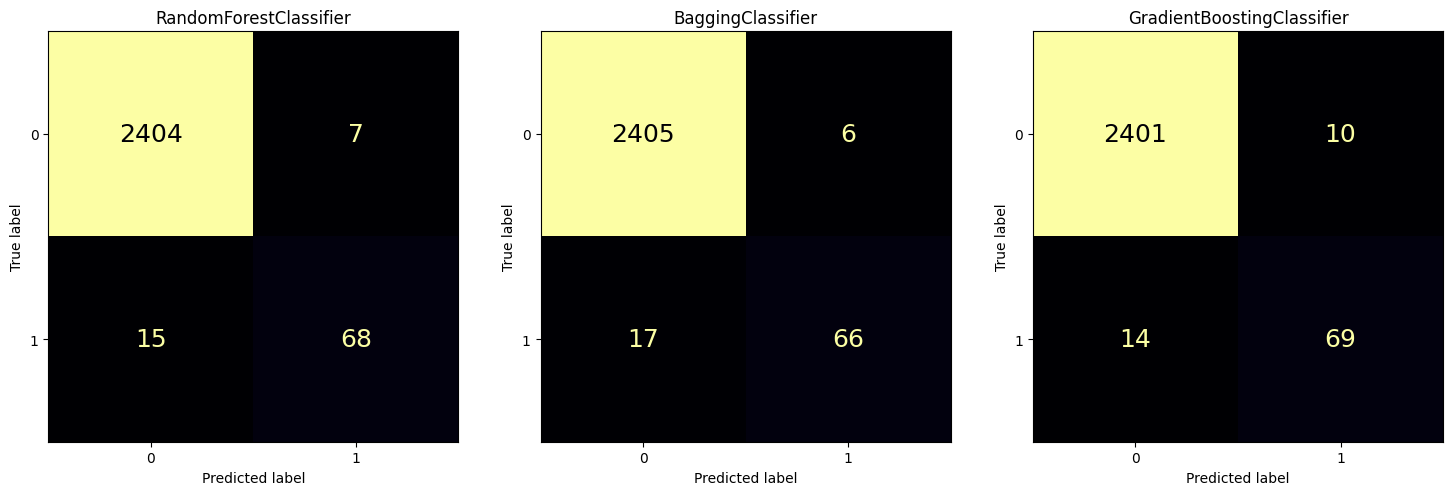

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the best models and sampling methods
path_to_pickle_file = ".././best_models_sampling.pkl"
with open(path_to_pickle_file, "rb") as file:
    best_models_sampling = pickle.load(file)


# Extract models and sampling methods
best_model_1 = best_models_sampling["best_model_1"]
best_sampling_1 = best_models_sampling["best_sampling_1"]

best_model_2 = best_models_sampling["best_model_2"]
best_sampling_2 = best_models_sampling["best_sampling_2"]

best_model_3 = best_models_sampling["best_model_3"]
best_sampling_3 = best_models_sampling["best_sampling_3"]

# Resample the training data
X_train_resampled_1, y_train_resampled_1 = best_sampling_1.fit_resample(X_train, y_train)
X_train_resampled_2, y_train_resampled_2 = best_sampling_2.fit_resample(X_train, y_train)
X_train_resampled_3, y_train_resampled_3 = best_sampling_3.fit_resample(X_train, y_train)

# Fit the models
best_model_1.fit(X_train_resampled_1, y_train_resampled_1)
best_model_2.fit(X_train_resampled_2, y_train_resampled_2)
best_model_3.fit(X_train_resampled_3, y_train_resampled_3)

# Predict on the test set
y_pred_1 = best_model_1.predict(X_test)
y_pred_2 = best_model_2.predict(X_test)
y_pred_3 = best_model_3.predict(X_test)

# Create confusion matrices
cm_1 = confusion_matrix(y_test, y_pred_1)
cm_2 = confusion_matrix(y_test, y_pred_2)
cm_3 = confusion_matrix(y_test, y_pred_3)

# Display confusion matrices using 'inferno' colormap with larger text
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
# fig.suptitle('Confusion Matrices of the Best Models')

font = {'size': 18}

ConfusionMatrixDisplay(cm_1).plot(ax=axes[0], cmap='inferno', colorbar=False)
axes[0].set_title('RandomForestClassifier')
for text in axes[0].texts:
    text.set_fontsize(18)

ConfusionMatrixDisplay(cm_2).plot(ax=axes[1], cmap='inferno', colorbar=False)
axes[1].set_title('BaggingClassifier')
for text in axes[1].texts:
    text.set_fontsize(18)

ConfusionMatrixDisplay(cm_3).plot(ax=axes[2], cmap='inferno', colorbar=False)
axes[2].set_title('GradientBoostingClassifier')
for text in axes[2].texts:
    text.set_fontsize(18)

plt.show()

In the provided matrices:

RandomForestClassifier: 68 TP, 2404 TN, 7 FP, 15 FN.

BaggingClassifier: 66 TP, 2405 TN, 6 FP, 17 FN.

GradientBoostingClassifier: 69 TP, 2401 TN, 10 FP, 14 FN.

### ROC - Curves

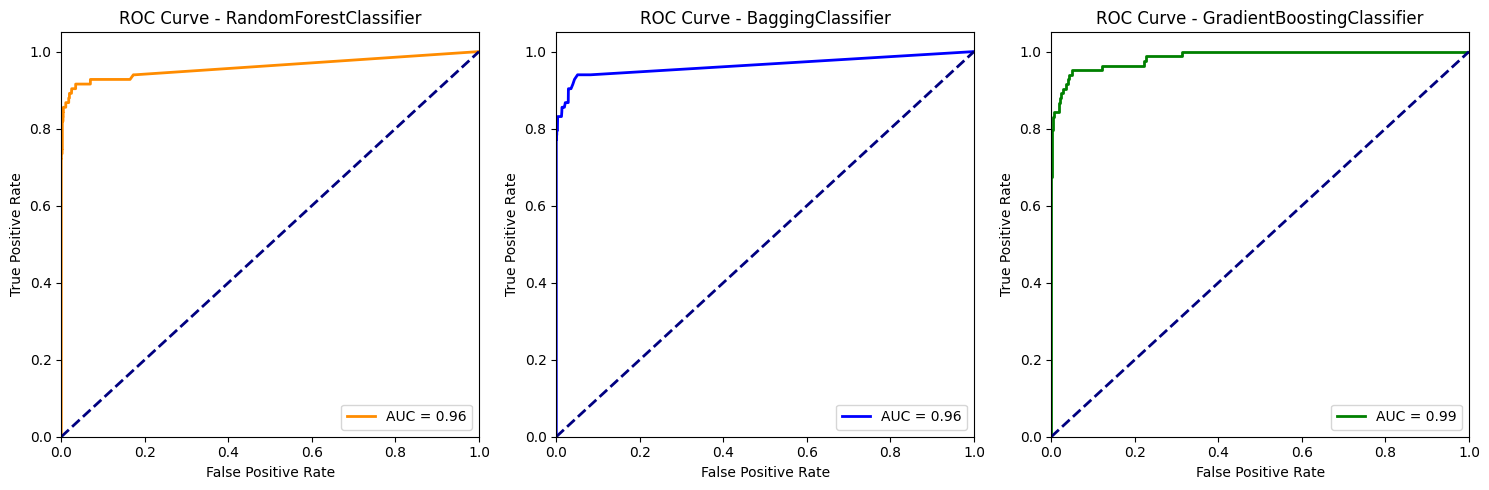

In [43]:
from sklearn.metrics import roc_curve, auc
# Predict probabilities on the test set
y_score_1 = best_model_1.predict_proba(X_test)[:, 1]
y_score_2 = best_model_2.predict_proba(X_test)[:, 1]
y_score_3 = best_model_3.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each model
fpr_1, tpr_1, _ = roc_curve(y_test, y_score_1)
roc_auc_1 = auc(fpr_1, tpr_1)

fpr_2, tpr_2, _ = roc_curve(y_test, y_score_2)
roc_auc_2 = auc(fpr_2, tpr_2)

fpr_3, tpr_3, _ = roc_curve(y_test, y_score_3)
roc_auc_3 = auc(fpr_3, tpr_3)

# Plot ROC curves individually
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# ROC for RandomForestClassifier
axes[0].plot(fpr_1, tpr_1, color='darkorange', lw=2, label=f'AUC = {roc_auc_1:0.2f}')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve - RandomForestClassifier')
axes[0].legend(loc="lower right")

# ROC for BaggingClassifier
axes[1].plot(fpr_2, tpr_2, color='blue', lw=2, label=f'AUC = {roc_auc_2:0.2f}')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - BaggingClassifier')
axes[1].legend(loc="lower right")

# ROC for GradientBoostingClassifier
axes[2].plot(fpr_3, tpr_3, color='green', lw=2, label=f'AUC = {roc_auc_3:0.2f}')
axes[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('ROC Curve - GradientBoostingClassifier')
axes[2].legend(loc="lower right")

plt.tight_layout()
plt.show()

##### Interpretation of the ROC Curves
- RandomForestClassifier:

AUC: 0.96
Indicates excellent performance with a high true positive rate and low false positive rate.
- BaggingClassifier:

AUC: 0.96
Also shows excellent performance similar to the 
- RandomForestClassifier.

AUC: 0.99
Shows the best performance with near-perfect discrimination between classes.

##### What shows the ROC Curve?
The ROC curve plots the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The AUC value indicates the overall ability of the model to discriminate between positive and negative classes, with higher values representing better performance.

### Feature Importance of RandomForestClassifier

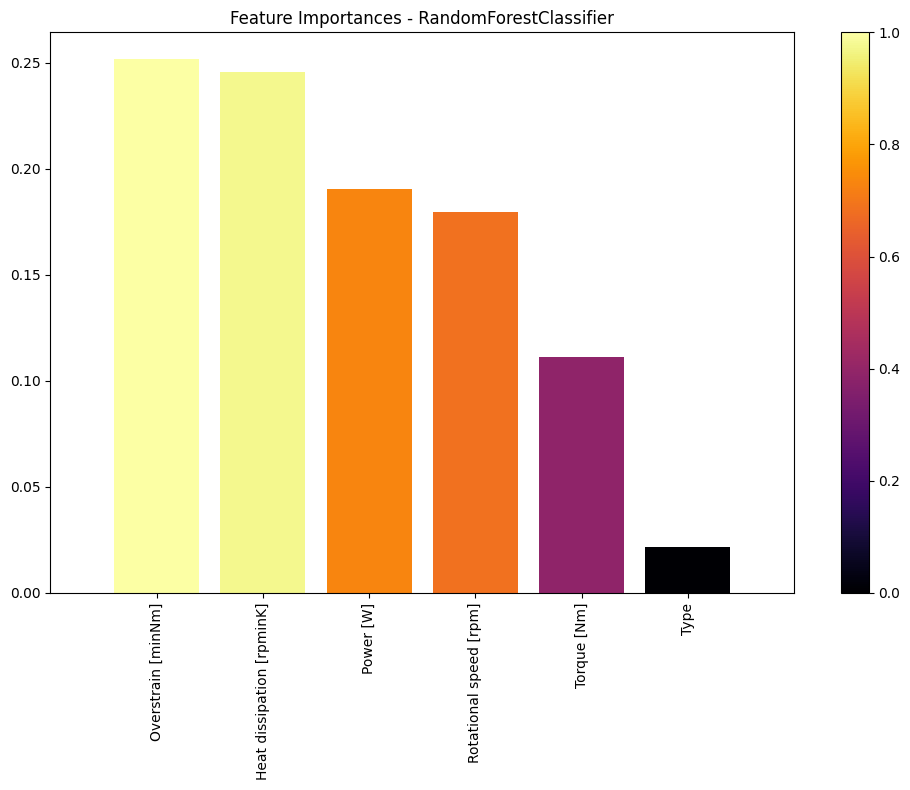

In [47]:
# Ensure the model is fitted
best_model_1 = RandomForestClassifier(n_estimators=60, min_samples_split=5, max_depth=30, criterion='entropy', random_state=42)
best_model_1.fit(X_train, y_train)

# Get feature importances
importances = best_model_1.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns

# Normalize the feature importances for color mapping
norm_importances = (importances - np.min(importances)) / (np.max(importances) - np.min(importances))
colors = plt.cm.inferno(norm_importances[indices])

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.title("Feature Importances - RandomForestClassifier")
bars = plt.bar(range(X_train.shape[1]), importances[indices], align="center", color=colors)
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.colorbar(plt.cm.ScalarMappable(cmap="inferno"), ax=plt.gca(), orientation="vertical")
plt.tight_layout()
plt.show()

##### Conclusion
The model relies heavily on Overstrain [min/Nm] and Heat dissipation [rpm/K] to make accurate predictions, followed by Power [W] and Rotational speed [rpm]. Features like Torque [Nm] and Type are less influential but still contribute to the overall prediction accuracy. Understanding these importances helps in focusing on the most critical variables and possibly refining or engineering new features to enhance model performance further.

### Precision-Recall Curve

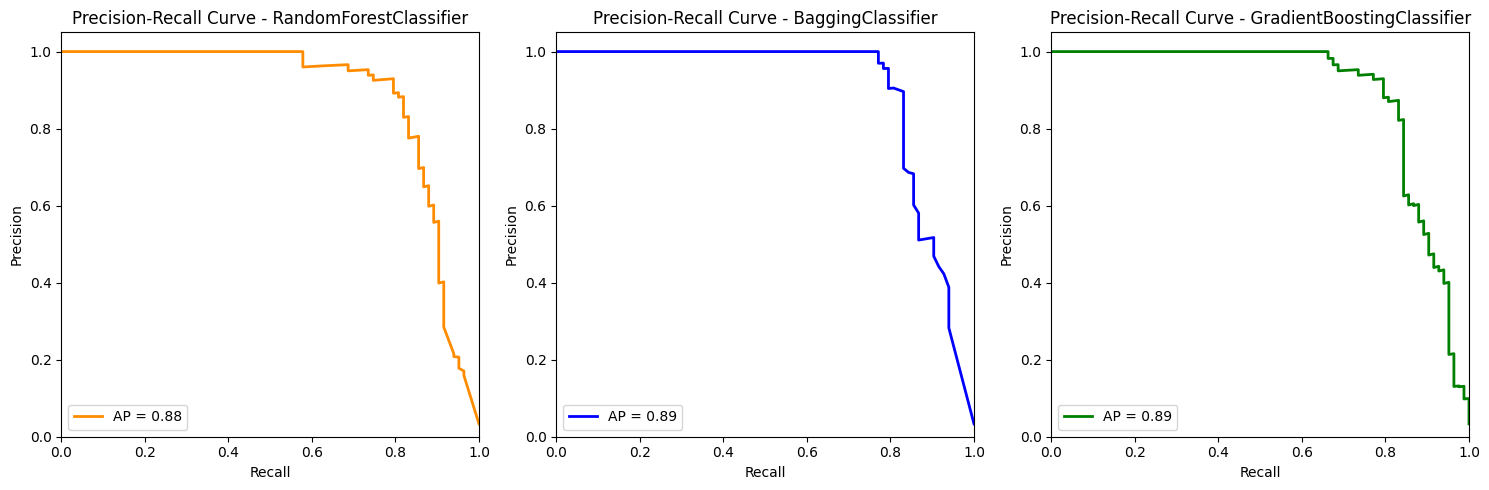

In [48]:
from sklearn.metrics import precision_recall_curve, average_precision_score
# Predict probabilities on the test set
y_score_1 = best_model_1.predict_proba(X_test)[:, 1]
y_score_2 = best_model_2.predict_proba(X_test)[:, 1]
y_score_3 = best_model_3.predict_proba(X_test)[:, 1]

# Compute Precision-Recall curve and average precision for each model
precision_1, recall_1, _ = precision_recall_curve(y_test, y_score_1)
average_precision_1 = average_precision_score(y_test, y_score_1)

precision_2, recall_2, _ = precision_recall_curve(y_test, y_score_2)
average_precision_2 = average_precision_score(y_test, y_score_2)

precision_3, recall_3, _ = precision_recall_curve(y_test, y_score_3)
average_precision_3 = average_precision_score(y_test, y_score_3)

# Plot Precision-Recall curves individually
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Precision-Recall for RandomForestClassifier
axes[0].plot(recall_1, precision_1, color='darkorange', lw=2, label=f'AP = {average_precision_1:0.2f}')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision-Recall Curve - RandomForestClassifier')
axes[0].legend(loc="lower left")

# Precision-Recall for BaggingClassifier
axes[1].plot(recall_2, precision_2, color='blue', lw=2, label=f'AP = {average_precision_2:0.2f}')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve - BaggingClassifier')
axes[1].legend(loc="lower left")

# Precision-Recall for GradientBoostingClassifier
axes[2].plot(recall_3, precision_3, color='green', lw=2, label=f'AP = {average_precision_3:0.2f}')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].set_title('Precision-Recall Curve - GradientBoostingClassifier')
axes[2].legend(loc="lower left")

plt.tight_layout()
plt.show()

All three classifiers exhibit high precision and recall, with an average precision score of 0.89, indicating they are highly effective in identifying true positives while keeping false positives low. The consistent performance across different models suggests that each is well-suited for the classification task at hand.

In [45]:
# Define the best models and sampling methods
best_model_1 = RandomForestClassifier(n_estimators=60, min_samples_split=5, max_depth=30, criterion='entropy', random_state=42)
best_sampling_1 = TomekLinks(n_jobs=-1)

best_models_sampling = {
    "best_model_1": best_model_1,
    "best_sampling_1": best_sampling_1
}
# Save the dictionary to a pickle file
path_to_pickle_file = ".././best_model_sampling.pkl"
with open(path_to_pickle_file, "wb") as file:
    pickle.dump(best_models_sampling, file)

print(f"The best model and sampling method have been saved to {path_to_pickle_file}.")

The best model and sampling method have been saved to .././best_model_sampling.pkl.
